In [1]:
import numpy as np
from qiskit import *

In [49]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PyQuanteDriver, UnitsType, BaseDriver
from qiskit.chemistry import FermionicOperator
import warnings
warnings.filterwarnings('ignore')

In [50]:
def get_qubit_op(dist):
    driver = PyQuanteDriver(atoms="Li .0 .0 .0; H .0 .0 " + str(dist), units=UnitsType.ANGSTROM, 
                         charge=0)
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift

In [51]:
get_qubit_op(4)

(<qiskit.aqua.operators.legacy.weighted_pauli_operator.WeightedPauliOperator at 0x1a29ec9780>,
 2,
 6,
 -7.003149843108497)

In [79]:


backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.039709910851991 Exact Energy: [-7.03973238]
Interatomic Distance: 0.6 VQE Result: -7.31334419655845 Exact Energy: [-7.31334574]
Interatomic Distance: 0.7 VQE Result: -7.500921012788252 Exact Energy: [-7.50092201]
Interatomic Distance: 0.8 VQE Result: -7.630976849078243 Exact Energy: [-7.63097818]
Interatomic Distance: 0.9 VQE Result: -7.7208107427430805 Exact Energy: [-7.72081235]
Interatomic Distance: 1.0 VQE Result: -7.782240620903167 Exact Energy: [-7.78224236]
Interatomic Distance: 1.1 VQE Result: -7.823597469174873 Exact Energy: [-7.82359925]
Interatomic Distance: 1.2 VQE Result: -7.850696603356411 Exact Energy: [-7.85069835]
Interatomic Distance: 1.3 VQE Result: -7.867561592137049 Exact Energy: [-7.86756327]
Interatomic Distance: 1.4 VQE Result: -7.87699986400254 Exact Energy: [-7.87700148]
Interatomic Distance: 1.5 VQE Result: -7.881014175687418 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881070661530747 Exact Ene

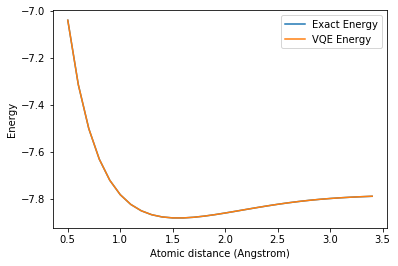

In [80]:
for i in range(len(exact_energies)):
    exact_energies[i] = exact_energies[i][0]


plt.plot(distances[:30], exact_energies[:30], label="Exact Energy")
plt.plot(distances[:30], vqe_energies[:30], label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [147]:
#V (r) = De(1 − e−α(r−r0))^2

def test_func(x, a, b, c, d):
    return a * ((1- np.exp(-b*(x-c)))**2) + d

# print(optimize.curve_fit(test_func, exact_energies, vqe_energies, p0=[2, 2]))
# print(vqe_energies)
# print(exact_energies)
params, params_covariance = optimize.curve_fit(test_func, distances, vqe_energies, p0=[1, -1, -1.9, -7.9])

print(params)
print(params[0], "*((1-np.exp(-", params[1], " * (x-", params[2], ")))**2) + ",params[3])

[ 0.32181962  0.86404801  1.60018092 -7.91006233]
0.32181962213092924 *((1-np.exp(- 0.8640480072433572  * (x- 1.600180918354498 )))**2) +  -7.9100623346458


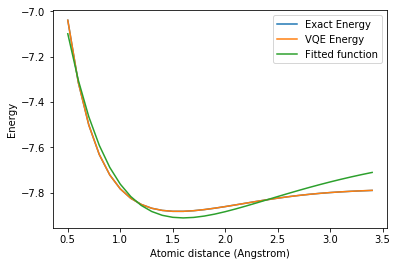

In [148]:
plt.plot(distances[:30], exact_energies[:30], label="Exact Energy")
plt.plot(distances[:30], vqe_energies[:30], label="VQE Energy")
fitted_energies = []
for i in range(len(exact_energies)):
#     print(test_func(distances[i], params[0], params[1], params[2]))
    fitted_energies.append(test_func(distances[i], params[0], params[1], params[2], params[3]))
plt.plot(distances[:30], fitted_energies[:30],label='Fitted function')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend(loc='best')
plt.show()



